In [ ]:
#ONLY CORRECTLY COREGISTERED RESULTS
# old net 2025-11-27T14:34:30.414570_model_weights.pth (16,32,64,128,256 channels, 2 res units)
# new net 2025-11-27T21:12:33.919655_model_weights.pth (32,64,128,256,512 channels, 6 res units)

In [ ]:
import pathlib as p
from functions import *
import nibabel as nib
import numpy as np
import random

DATA_DIR = p.Path.home()/"data"/"bobsrepository"
file_dir = DATA_DIR/"coregistered"
t1_files = sorted(file_dir.rglob("*T1w.nii.gz"))
t2_files = sorted(file_dir.rglob("*T2w.nii.gz"))
t2_LR_files = sorted(file_dir.rglob("*T2w_LR.nii.gz"))
t2_LR4_files = sorted(file_dir.rglob("*T2w_LR4.nii.gz"))

In [18]:
files = list(zip(t1_files, t2_files, t2_LR_files))
files4 = list(zip(t1_files, t2_files, t2_LR4_files))
train, val, test = split_dataset(files)
train4, val4, test4 = split_dataset(files4)

patch_size = (32, 32, 32)
stride = (16, 16, 16)
target_shape = (192, 224, 192)  


In [23]:
real = nib.load(test[0][1])
real = normalize(real)
nib.save(real, "/Users/al1612le/images/coregistered/gt_normalized.nii.gz")

In [13]:
test_t1, test_t2, test_t2_LR, affine = get_patches(test, patch_size, stride, target_shape)


In [ ]:
#TEST

import torch
from monai.networks.nets import UNet
from monai.networks.layers.factories import Norm

net = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    channels=(32, 64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2, 2),
    num_res_units=10, 
    norm=None,
)
net.load_state_dict(torch.load(DATA_DIR/"outputs"/"2025-11-27T21:12:33.919655_model_weights.pth", map_location="cpu"))

generated_images = []
real_images = []
net.eval()
with torch.no_grad():
    for i in range(len(test_t1)):
        all_outputs = []
        for j in range(len(test_t1[0])):
            input1 = torch.tensor(test_t1[i][j]).float()
            input2 = torch.tensor(test_t2_LR[i][j]).float()
            inputs = torch.stack([input1, input2], dim=0).unsqueeze(0)
            output = net(inputs)
            all_outputs.append(output.squeeze(0).squeeze(0).cpu().numpy()) 
        gen_reconstructed = reconstruct_from_patches(all_outputs, target_shape, stride)
        real_reconstructed = reconstruct_from_patches(test_t2[i], target_shape, stride)
        generated_images.append(gen_reconstructed)
        real_images.append(real_reconstructed)
        print(f"Processed test image {i+1}/{len(test_t1)}")


/var/folders/j3/fb9w9g7s1vqdx2y5by7m63180000gp/T/ipykernel_55960/1754604270.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(DATA_DIR/"out

Processed test image 1/11
Processed test image 2/11
Processed test image 3/11
Processed test image 4/11
Processed test image 5/11
Processed test image 6/11
Processed test image 7/11
Processed test image 8/11
Processed test image 9/11
Processed test image 10/11
Processed test image 11/11


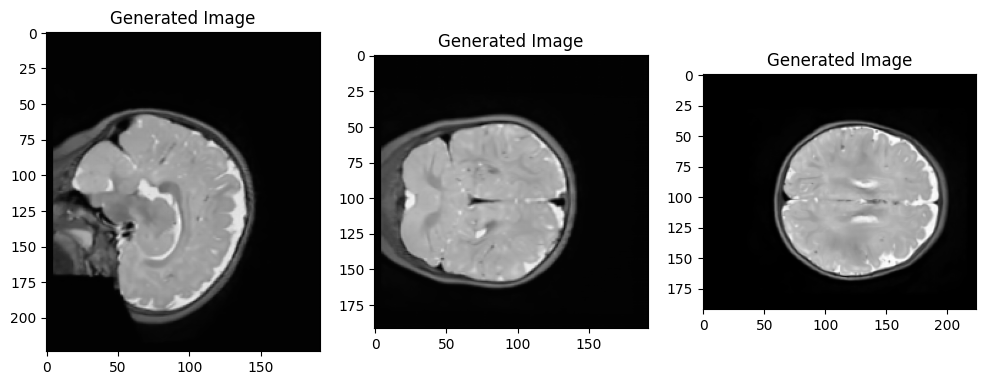

In [21]:
#Plot and save
import matplotlib.pyplot as plt
mid_slice = target_shape[0] // 2
plt.figure(figsize=(12, 8))
plt.subplot(1,3,1)
plt.title("Generated Image")
plt.imshow(generated_images[0][mid_slice,:,:], cmap='gray')
plt.subplot(1,3,2)
plt.title("Generated Image")
plt.imshow(generated_images[0][:,mid_slice,:], cmap='gray')
plt.subplot(1,3,3)
plt.title("Generated Image")
plt.imshow(generated_images[0][:,:,mid_slice], cmap='gray')
plt.show()

nib.save(nib.Nifti1Image(generated_images[0], affine), "/Users/al1612le/images/coregistered/newnet_first_test.nii.gz")